# Lab Assignment: Analyzing Laerner Interactions in MOOC Discussion Forums

In this assignment, we've taken the data from the forums of a previous iteration of the MOOC *Big Data
and Education*, from week 1.

The data set for this assignment has four columns: 

- the post ID, 
- the poster’s ID, 
- the thread the post was in, and 
- which post this post was a response to

Python code is provided below to help you get started but you can use any tool you want to complete this assignment. 

Note: Different software packages may differ in how they name or calculate a specific measure (e.g., whether to normalize a centrality measure by default). 

This assignment is focused on getting yourself familiar with the workflow of dealing with a realworld dataset from a digital learning platform, so don't worry about inconsistencies or "errors" when submitting your responses on ASSISTments. 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Read data and preparing data

In NetworkX, you can read network data from different formats, such as `adjascency list`, `adjascency matrix`, `edge list`, etc. 

In order to read data into NetworkX, you need to first transform your data into a proper format that is acceptable for NetworkX. This process applies to any other SNA software packages. 

See [this NetworkX reference page](https://networkx.org/documentation/stable/reference/readwrite/index.html) for details. 

For the MOOC dataset we will work with, it's already in the edge list format. 

Let's read it in to a pandas dataframe and inspect its content. 

In [2]:
edge_list = pd.read_csv("https://learninganalytics.upenn.edu/ryanbaker/EDM2014/ba5-data.txt", delimiter='\t')
edge_list

,ID,poster,thread,response-to
0,1,69497,1,NaN
1,2,44591,2,NaN
2,3,24601,2,2.0
3,4,74570,3,NaN
4,5,29022,3,4.0
...,...,...,...,...
193,194,73263,47,193.0
194,195,68491,47,193.0
195,196,26362,47,195.0
196,197,4582,47,195.0


### Data prep

Even though the data structure looks good, the last column seems to be treated as a `numeric` data type.

So we still need to do convert it to the `integer` type to make sure its data type is consistent with the `poster` column. 

In [3]:
edge_list['response-to'] = edge_list['response-to'].fillna(0).astype(int)
print(edge_list.dtypes)


ID             int64
poster         int64
thread         int64
response-to    int64
dtype: object


## Create a directed network from data

With the cleaned edge list, we can create a directed graph, and add the edge list in. 

There is a function named `add_edges_from` that can be used to quickly add the edges all at once.

However, we may want to keep two columns -- `ID` and `thread` -- as edge attributes. So we go through the edge list row by row and add one edge at a time with its attributes. 

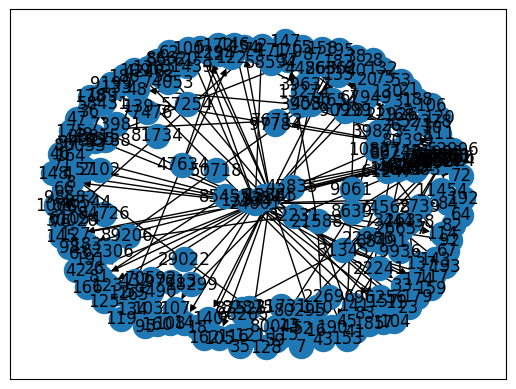

In [4]:
graph = nx.DiGraph()

# Add edges with attributes from the DataFrame to the graph
for _, row in edge_list.iterrows():
    graph.add_edge(row['poster'], row['response-to'], id = row['ID'], thread=row['thread'])

# Generate a quick network visualization
nx.draw_networkx(graph)

Let's check attributes of the edge from `24601` to `0`:

In [5]:
graph.get_edge_data(24601, 0)

{'id': 153, 'thread': 37}

It's always a good idea to check the original dataset for any "bugs".

So let's check whether edges between these two nodes. 

In [6]:
edge_list[(edge_list['poster'] == 24601) & (edge_list['response-to'] == 0)]

,ID,poster,thread,response-to
112,113,24601,27,0
152,153,24601,37,0


Interesting!! 

Only the edge with ID of 153 is reflected in the NetworkX graph object.

This warrants additional investigation.

Aha! -- On the [DiGraph reference page](https://networkx.org/documentation/stable/reference/classes/digraph.html), there is one important sentence:

> DiGraphs hold directed edges. Self loops are allowed but multiple (parallel) edges are not.

It seems DiGraph only allows one edge between any pair of nodes, so some data were thrown away when multiple edges are observed between two nodes. 

We need to find a solution to deal with this issue.

## Weighted directed network

There could be multiple solutions, depending on your goal. 

One possible solution is to merge multiple edges into one weighted edge. 

This preserves the number of occurrences but throws away the original edge attributes such as ID and thread. 

Whether this is a good solution, again, depends on your goal. 

### Created a new edge list data frame with a `weight` column

In [7]:
el_weighted = edge_list.groupby(['poster', 'response-to']).size().reset_index(name='weight')
el_weighted.sort_values(by=['weight', 'poster'], ascending=[False, True]) # Inspect the weighted edge list, sorted by weight and poster

,poster,response-to,weight
62,22986,0,2
65,24601,0,2
88,24627,0,2
99,31345,0,2
179,85455,166,2
...,...,...,...
188,97013,103,1
189,97784,0,1
190,97784,189,1
191,98582,60,1


## Created a weighted directed network

Now, with the weighted edge list, we can follow the same process and generate a new network. 

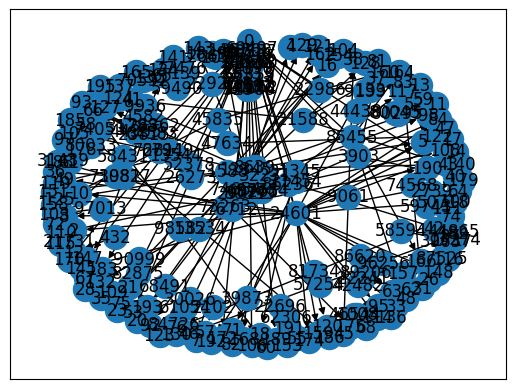

In [8]:
wg = nx.DiGraph()

# Add edges with attributes from the DataFrame to the graph
for _, row in el_weighted.iterrows():
    wg.add_edge(row['poster'], row['response-to'], weight = row['weight'])

# Generate a quick network visualization
nx.draw_networkx(graph)

Let's check the edge from `24601` to `0` just to be safe:

In [9]:
wg.get_edge_data(24601, 0)

{'weight': 2}

## Network analysis

With the created network, we can then conduct further analysis of the network. 

Below are a few analyses for illustration purposes:

In [10]:
nx.shortest_path_length(wg, 3903, 0)

1

In [11]:
in_degrees = dict(wg.in_degree(weight='weight'))
in_degrees

{432: 0,
 12: 1,
 1008: 0,
 68: 2,
 1588: 0,
 104: 1,
 109: 1,
 2102: 0,
 57: 1,
 2739: 0,
 64: 1,
 3903: 0,
 0: 48,
 37: 2,
 40: 2,
 48: 1,
 4582: 0,
 195: 2,
 8639: 0,
 128: 1,
 130: 1,
 9061: 0,
 38: 1,
 45: 1,
 9199: 0,
 133: 1,
 9936: 0,
 137: 1,
 10162: 0,
 10827: 0,
 65: 1,
 67: 1,
 11454: 0,
 82: 1,
 84: 2,
 12345: 0,
 5: 2,
 11: 1,
 16: 1,
 20: 1,
 23: 1,
 55: 1,
 75: 1,
 105: 1,
 121: 1,
 123: 1,
 125: 1,
 127: 1,
 129: 1,
 140: 1,
 143: 1,
 146: 1,
 151: 1,
 154: 1,
 162: 1,
 182: 1,
 13274: 0,
 87: 4,
 13534: 0,
 185: 1,
 186: 1,
 13544: 0,
 183: 1,
 14644: 0,
 18299: 0,
 107: 1,
 20757: 0,
 21090: 0,
 21588: 0,
 41: 1,
 43: 1,
 21731: 0,
 115: 1,
 22241: 0,
 33: 1,
 22696: 0,
 153: 1,
 22926: 0,
 135: 1,
 22986: 0,
 13: 1,
 23815: 0,
 93: 3,
 24601: 0,
 2: 1,
 8: 1,
 10: 1,
 14: 1,
 17: 1,
 26: 1,
 47: 1,
 49: 1,
 71: 1,
 81: 1,
 95: 1,
 100: 1,
 114: 1,
 145: 1,
 148: 1,
 157: 2,
 159: 1,
 174: 1,
 179: 2,
 192: 1,
 24627: 0,
 25133: 0,
 26273: 0,
 53: 1,
 26362: 0,
 2665

In [12]:
nx.density(wg)

0.0034799855751893255

In [13]:
"{:.4f}".format(nx.overall_reciprocity(wg))

'0.0000'

### Prettify the network visualization

You can fine-tune the way the network is visualized, using features provided by NetworkX, or even other packages (such as `pyvis` that can generate interactive plots). 

Below is a quick attempt to adjust the node size, edge width, coloring, and graph layout. 

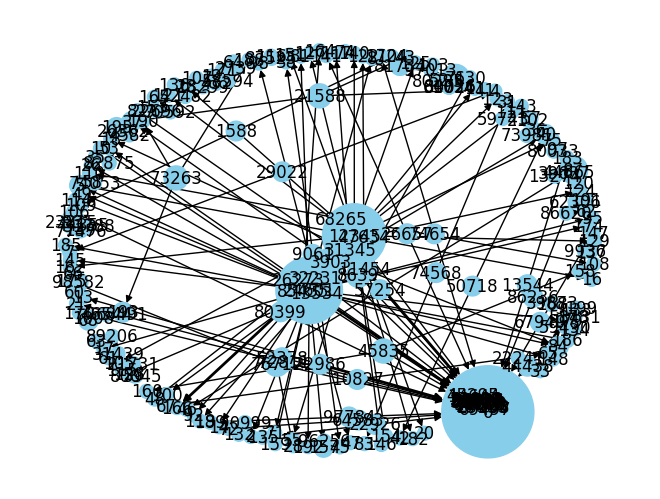

In [14]:
# Calculate node degrees
degrees = dict(wg.degree())

# Extract edge weights
edge_weights = [data['weight'] for _, _, data in wg.edges(data=True)]

# Scale node sizes based on degrees for visualization
node_sizes = [v * 100 for v in degrees.values()]

# Draw the graph with customized edge width and node size
pos = nx.spring_layout(wg, iterations=200)  # You can choose a different layout algorithm
nx.draw(wg, pos, with_labels=True, node_size=node_sizes, width=edge_weights, edge_color='black', node_color='skyblue')

plt.show()